# Correlation and covariance

Peter Ralph

https://uodsci.github.io/dsci345

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd
from dsci345 import pretty

rng = np.random.default_rng()

$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}} \newcommand{\var}{\text{var}} \newcommand{\sd}{\text{sd}} \newcommand{\cov}{\text{cov}}$$
This is here so we can use `\P` and `\E` and `\var` and `\cov` and `\sd` in LaTeX below.

# Covariance, and correlation

## Definitions

For random variables $X$ and $Y$,
$$\begin{aligned}
    \cov[X, Y]
    &=
    \E[(X - \E[X])(Y - \E[Y])] \\
    &=
    \E[XY] - \E[X] \E[Y] ,
\end{aligned}$$
and
$$
    \text{cor}[X, Y]
    =
    \frac{
        \cov[X, Y]
    }{
        \sd[X] \sd[Y]
    } 
$$

*Properties:*

If $a$ is nonrandom and $Z$ is another random variable, then
$$\begin{aligned}
    \text{(constants)}  \qquad & \cov[a, X] = 0 \\
    \text{(bilinearity)}  \qquad & \cov[a X + Y, Z] = a \; \cov[X, Z] + \cov[Y, Z] .
\end{aligned}$$

## Example

Let $Z_1$, $Z_2$, and $Z_3$ be independent Normal(0, 1),
and
$$\begin{aligned}
    X &= \frac{1}{\sqrt{2}}\left( Z_1 + Z_2 \right) \\
    Y &= \frac{1}{\sqrt{2}}\left( Z_2 + Z_3 \right) .
\end{aligned}$$
Then
$$\begin{aligned}
    X &\sim \text{Normal}(0, 1) , \\
    Y &\sim \text{Normal}(0, 1) ,
\end{aligned}$$
and
$$\begin{aligned}
    \cov[X, Y]
    &=
    \frac{1}{2}
    \E[(Z_1 + Z_2)(Z_2 + Z_3)] \\
    &=
    \frac{1}{2} .
\end{aligned}$$

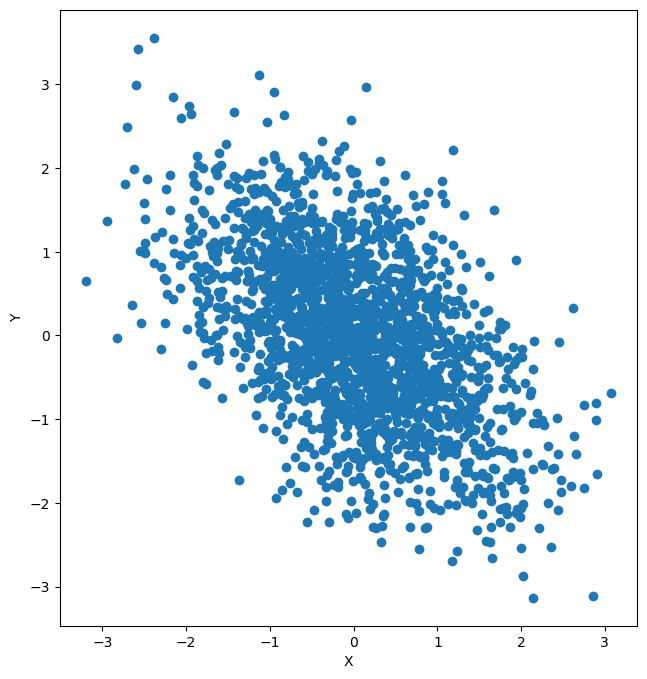

In [6]:
Z = rng.normal(size=(3, 2000))
X = ( Z[0,:] + Z[1,:] ) / np.sqrt(2)
Y = ( Z[1,:] + Z[2,:] ) / np.sqrt(2)
fig, ax = plt.subplots()
ax.scatter(X, Y); ax.set_aspect(1)
ax.set_xlabel("X"); ax.set_ylabel("Y");

## Exercise:

Modify the example so that $\cov[X, Y] = - 1/2$ (and so the plot tilts the other way).

# Multivariate data

Suppose we have a bunch of data, like
$$ 
\begin{bmatrix}
X_{11} & X_{12} & \cdots & X_{1k} \\
X_{21} & X_{22} & \cdots & X_{2k}\\
\vdots & \vdots & \ddots & \vdots \\
X_{n1} & \cdots & \cdots &X_{nk}
\end{bmatrix}
$$
where
$$\begin{aligned}
    X_{i \cdot} &= \text{(one observation)} \\
    X_{\cdot j} &= \text{(one variable)} .
\end{aligned}$$

How do we describe relationships between the variables?

The **sample covariance matrix** of a dataset is
$$ C_{jk} = \cov[X_{\cdot j}, X_{\cdot k}]  $$
(and the *sample covariance* is computed just like the sample variance).

## Example

Say we have measurements of lots of trees, for:

0. age,
1. height,
2. number of leaves, and
3. number of other trees within 5m.

*Which correlations will be positive? Negative?*

Here is a hopefully interesting but not terribly realistic simulation:

In [7]:
n = 2000
age = rng.exponential(scale=100, size=n)
height = rng.gamma(scale=np.sqrt(age), shape=np.sqrt(age), size=n)
leaves = np.round(rng.normal(loc=height*1000, scale=height*400, size=n))
others = rng.poisson((25 * np.pi / 4) * np.exp(-height/100))
X = np.column_stack([age, height, leaves, others])
np.corrcoef(X.T)

array([[ 1.        ,  0.94383522,  0.82885795, -0.74402384],
       [ 0.94383522,  1.        ,  0.8747281 , -0.76754488],
       [ 0.82885795,  0.8747281 ,  1.        , -0.67189109],
       [-0.74402384, -0.76754488, -0.67189109,  1.        ]])

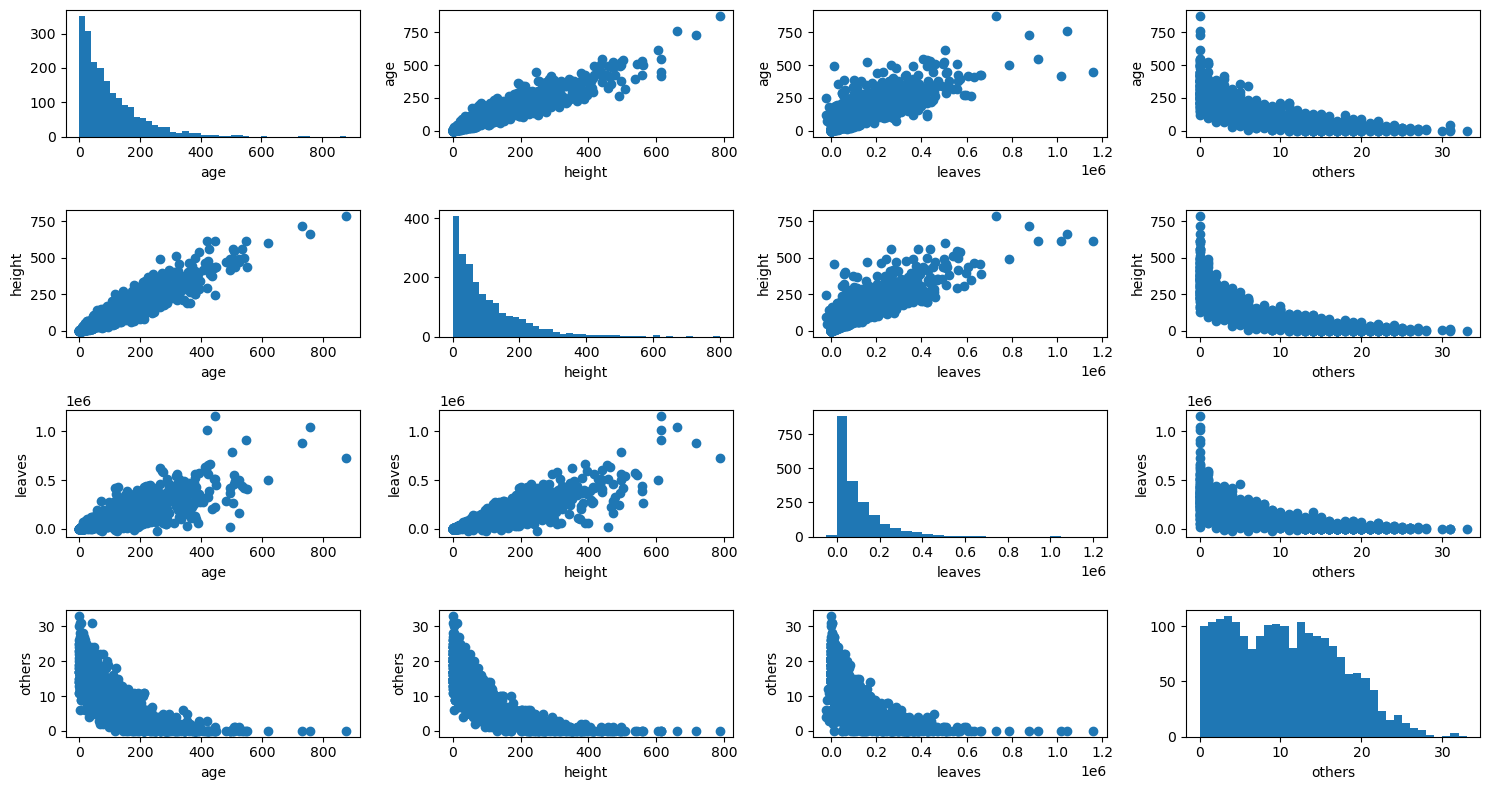

In [8]:
fig, axes = plt.subplots(4, 4)
names = ['age', 'height', 'leaves', 'others']
for i in range(4):
    for j in range(4):
        ax = axes[i][j]
        if i == j:
            ax.hist(X[:,i], bins=pretty(X[:,i], 40)); ax.set_xlabel(names[i])
        else:
            ax.scatter(X[:,j], X[:,i]); ax.set_xlabel(names[j]); ax.set_ylabel(names[i])
            
plt.tight_layout()

**Exercise:**
Come up with at least three variables that are correlated,
including at least one *negative* correlation,
and check your neighbor agrees.

# The Multivariate Normal distribution

However: how can we produce a *particular* covariance matrix? Here's one way...

First, recall some facts about the Normal:
if
$$
    X_i \sim \text{Normal}(\text{mean}=\mu_i, \text{sd}=\sigma_i), \qquad 0 \le i \le k-1,
$$
are independent, and $a$ and $b$ are nonrandom, then:

1. $X_1 + \cdots + X_k$ is Normal, with mean $\mu_1 + \cdots + \mu_k$
    and SD $\sqrt{\sigma_1^2 + \cdots + \sigma_k^2}$.

2. $a X_i + b$ is Normal($a \mu_i + b$, $a\sigma_i$).

So: if $Z_1, \ldots, Z_k$ are independent Normal(0,1)
and $A$ is an $k \times k$ matrix,
then
$$ X = AZ $$
is a $k$-dimensional random variable and
$$ X \sim \text{Normal}(0, A A^T) .$$

In other words,
$$ \cov[ X_i, X_j ] = \cov[(AZ)_i, (AZ)_j] = \left(A A^T \right)_{ij} = \sum_\ell A_{i \ell} A_{j \ell} . $$

**So,** here's a recipe to simulate from the **multivariate Normal:**
$$ X \sim \text{Normal}(\text{mean}=a, \text{cov}=C) .$$

1. Let $A$ be the Cholesky factor of $C$ (so $C = A A^T$).
2. Choose $Z$ to be a vector of independent Normal(0, 1).
3. Let $X = a + AZ$.

## Example:

Simulate 1,000 draws from a Normal with mean 0 and covariance matrix
$$
    C = \begin{bmatrix}
        1 & 0.8 & -0.4 \\
        0.8 & 1 & -0.8 \\
        -0.4 & -0.8 & 1
    \end{bmatrix} .
$$

In [28]:
Z = rng.normal(0, 1, size=3 * 1000).reshape((3, 1000))
C = np.array([[1, 0.8, -0.4],
             [0.8, 1, -0.8],
             [-0.4, -0.8, 1]])
A = np.linalg.cholesky(C)
X = np.matmul(A, Z)

In [23]:
np.cov(X)

array([[ 0.94114724,  0.74434802, -0.36407428],
       [ 0.74434802,  0.93501757, -0.74088273],
       [-0.36407428, -0.74088273,  0.92561342]])

## Exercise:

Simulate 1,000 draws from a Normal with mean $\mu = (10, 20, 30)$ and covariance matrix
$$
    C = \begin{bmatrix}
        1 & -1 & -1 \\
        -1 & 3 & -3 \\
        -1 & -3 & 10
    \end{bmatrix} .
$$
What is its correlation matrix?